In [1]:
# Import numerical python libraries to create vectors and perform matrix multiplication
import torch
import numpy as np

# Import pyplot plotting library from matplotlib to plot similar to Matlab
import matplotlib.pyplot as plt

# Import Image library from PIL (pillow) to load images for display purposes
from PIL import Image

# Import necessary Pytorch libraries for building neural networks, optimization, and dataloading
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, random_split

from torchvision import transforms, datasets

# Import a visualization library to display a summary of the models we build
from torchsummary import summary

# Import some helpful metrics to help us understand the models performance
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Import a locally developed library to perform printing functions
import uwyo_common as common

In [2]:
"""
    build_model(image_width, image_height)
    A function to build and test pytorch models. This function is static and must change when a new
    model is desired.
    
    inputs:
     - image_width (int): The expected image weight to be processed
     - image_height (int): The expected image height to be processed
    outputs:
     - model (pytorch model): The resultant pytorch model
"""
def build_model(image_width, image_height):
    
    model = nn.Sequential() # Start with a blank model with no layers
    dummy = torch.ones((1, 1, image_width, image_height)) # 'Dummy' image to check outputs at each layer
    
    # Add Convolution layers for efficient image processing
    # Add pooling layers to both reduce the image size and to summarize important features
    # Add batch normalization layers to reduce covariate shift 
    # The proper layer order is convolution -> pooling -> batch normalization (repeat)
    layer_name = 'conv1'
    model.add_module(layer_name, nn.Conv2d(in_channels=1, out_channels=128, kernel_size=3))
    model.add_module(layer_name + ' act', nn.ReLU())
     
    layer_name = 'pool1'
    model.add_module(layer_name, nn.MaxPool2d(kernel_size=3))
    
    layer_name = 'batch norm 1'
    inputs = model(dummy).shape[1]
    model.add_module(layer_name, nn.BatchNorm2d(num_features=inputs))
    
    layer_name = 'conv2'
    model.add_module(layer_name, nn.Conv2d(in_channels=128, out_channels=32, kernel_size=3))
    model.add_module(layer_name + ' act', nn.ReLU())

    layer_name = 'pool2'
    model.add_module(layer_name, nn.MaxPool2d(kernel_size=3))
    
    layer_name = 'batch norm 2'
    inputs = model(dummy).shape[1]
    model.add_module(layer_name, nn.BatchNorm2d(num_features=inputs))

    # Add a flatten layer to transition from convolution layers to linear layers
    # Add linear layers to increase model complexity
    # The proper layer order is flatten -> linear layers -> output
    layer_name = 'flatten'
    model.add_module(layer_name, nn.Flatten())

    layer_name = 'linear 1'
    inputs = model(dummy).shape[1]
    model.add_module(layer_name, nn.Linear(inputs, 128))
    model.add_module(layer_name + ' act', nn.ReLU())

    # Add a linear layer for the output, this is always your last layer
    layer_name = 'output'
    inputs = model(dummy).shape[1]
    model.add_module(layer_name, nn.Linear(inputs, 19))
    model.add_module(layer_name + ' act', nn.Softmax(-1))
    
    summary(model, (1,image_width, image_height))
    
    return model

In [3]:
"""
    load_data(path, batch_siz, image_width, image_height, transform_train, transform_test, valid, display)
    A function to automate loading image datasets to be used for training and testing
    pytorch image models. If the image folder is not divided into training and testing 
    or training and validation and testing, then it is assumes the images are sorted by 
    class and will be divided into an 80 - 20 or 80 - 10 - 10 split depending on valid
    boolean value.
    
    inputs:
     - path (string): Path to the base folder where the images have been sorted.
     - batch_size (int): The number of examples per batch
     - image_width (int): The transformed image width
     - image_height (int): The transformed image height
     - transform_train (pytorch transform): A transformation to use when loading training images
     - transform_test (pytorch transform): A tranformation to use when loading testing images
     - valid (boolean): Is there a validation dataset?
     - display (boolean): Should examples be shown?
    outputs:
     - train_dl (pytorch dataloader): The dataloader for the training dataset
     - valid_dl (pytorch dataloader): The dataloader for the validation dataset
     - tests_dl (pytorch dataloader): The dataloader for the testing dataset
     - labels (list): The strings representing the text labels
"""
def load_data(path, batch_size=64, image_width=64, image_height=64, transform_train=None, transform_test=None, valid=True, display=False):
    # Transform to be used on our training/validation dataset if none were specified
    if transform_train is None:
        transform_train = transforms.Compose([transforms.Resize([image_width, image_height]),
                                              transforms.Grayscale(num_output_channels=1),
                                              transforms.ToTensor(), ])
    
    # Transform to be used on our testing dataset if none were specified
    if transform_test is None:
        transform_test = transforms.Compose([transforms.Resize([image_width, image_height]),
                                             transforms.Grayscale(num_output_channels=1),
                                             transforms.ToTensor(), ])
    
    dictionary = {'label name':[],'files':[],'label int':[]}
    
    try:
        # Create datasets from the specified presplit path
        train_dataset = datasets.ImageFolder(path + '/training/', transform=transform_train)
        valid_dataset = datasets.ImageFolder(path + '/validation/', transform=transform_train) if valid else None
        tests_dataset = datasets.ImageFolder(path + '/testing/', transform=transform_test)   
        images = train_dataset.imgs
    except:
        # Create a single dataset from the specified path to split later
        dataset = datasets.ImageFolder(path, transform=transform_train)
        generator = torch.Generator().manual_seed(42)
        if valid:
            train_dataset, valid_dataset, tests_dataset = random_split(dataset=dataset, lengths=[0.8, 0.1, 0.1], generator=generator)
        else:
            train_dataset, tests_dataset = random_split(dataset=dataset, lengths=[0.8, 0.2], generator=generator)
        images = dataset.imgs
    
    # Strip the labels from the dataloader object
    for image in images:
        if image[1] not in dictionary['label int']:
            dictionary['files'].append(image[0])
            dictionary['label int'].append(image[1])
            label_split = image[0].split('\\')
            label_name = label_split[1] if len(label_split) > 2 else label_split[0].split('/')[-1]
            dictionary['label name'].append(label_name)
        
    # Printing out the lengths of our datasets:
    message = f'Training dataset length: {len(train_dataset)}\n'
    message += f'Validation dataset length: {len(valid_dataset)}\n' if valid else ''
    message += f'Testing dataset length: {len(tests_dataset)}'
    common.Print(message)
    
    # Training Dataloader
    train_dl = DataLoader(train_dataset, batch_size, shuffle=True)

    # Validation Dataloader
    valid_dl = DataLoader(valid_dataset, batch_size, shuffle=False) if valid else None

    # Testing Dataloader
    tests_dl = DataLoader(tests_dataset, len(tests_dataset), shuffle=False)

    # Print how many batches will be in our training/validation dataloaders (dependent on batch_size)
    message = f'Number of training batches: {len(train_dl)}\n'
    message += f'Number of validation batches: {len(valid_dl)}\n' if valid else ''
    message += f'Number of testing batches: {len(tests_dl)}'
    common.Print(message)
    
    labels = dictionary['label name']
    # Display examples from each class
    if display:
        cols = 5
        rows = int(len(labels) / cols) + 1
        fig = plt.figure(figsize=(2*cols,2*rows))
        for index, file in enumerate(dictionary['files']):
            image = Image.open(file)
            sub_plot = fig.add_subplot(rows, cols, index+1)
            sub_plot.set_title(f'{index} {labels[index]}')
            sub_plot.tick_params(left=False, right=False, labelleft=False, labelbottom=False, bottom=False)
            plt.imshow(image)
        
    # Display the mapping from int to string for each class
    else:
        message = 'Labels\n'
        for index, label in enumerate(labels):
            message += f'{index} -> {label}\n'
        common.Print(message)
    
    # Return a validation dataloader
    if valid:
        return train_dl, valid_dl, tests_dl, labels
    
    # Do not return a validation dataloader
    else:
        return train_dl, tests_dl, labels

In [4]:
"""
    plot_history(history)
    A function to automate plotting all of the metrics tracked in the 
    history dictionary during training. If a validation dataset was used
    the validation metrics are plotted on the save graph as the training
    metrics.
    
    inputs:
     - history (dictionary): The dictionary of metrics from training
    outputs:
     -
"""
def plot_history(history):
    keys = list(history.keys())
    epochs = len(history[keys[0]])
    x = range(epochs)
    val = 'val_loss' in keys
    num_keys = int(len(keys)/2) if val else len(keys)
    fig, ax = plt.subplots(1, num_keys, figsize=(12,4))
    
    for i in range(num_keys):
        y1 = history[keys[i]]
        ax[i].plot(x, y1, label='Train')
        if val:
            ax[i].plot(x, y2, label='Valid')
        ax[i].set_xlabel('Epoch')
        ax[i].set_ylabel(keys[i])
        ax[i].grid(True)
    
    plt.show()

In [5]:
"""
    set_loss_fn(name)
    A function to wrap the available pytorch loss functions so that
    the training function can reference the loss function using a 
    string. For information on how each loss function works please
    refer to pytorch's online documentation.
    
    inputs:
     - name (string): The name of the loss function to use
    outputs:
     - loss (reference): A reference to the pytorch loss function
"""
def set_loss_fn(name):
    try:
        name = name.lower()
        losses = {'l1':nn.L1Loss,
                 'mse':nn.MSELoss,
                 'crossentropy':nn.CrossEntropyLoss,
                 'ctc':nn.CTCLoss,
                 'nll':nn.NLLLoss,
                 'poissonnll':nn.PoissonNLLLoss,
                 'gaussiannll':nn.GaussianNLLLoss,
                 'kldiv':nn.KLDivLoss,
                 'bce':nn.BCELoss,
                 'bcewithlogits':nn.BCEWithLogitsLoss,
                 'marginranking':nn.MarginRankingLoss,
                 'hingeembedding':nn.HingeEmbeddingLoss,
                 'multilabelmargin':nn.MultiLabelMarginLoss,
                 'huber':nn.HuberLoss,
                 'smoothl1':nn.SmoothL1Loss,
                 'softmargin':nn.SoftMarginLoss,
                 'multilabelsoftmargin':nn.MultiLabelSoftMarginLoss,
                 'cosineembedding':nn.CosineEmbeddingLoss,
                 'multimargin':nn.MultiMarginLoss,
                 'tripletmargin':nn.TripletMarginLoss,
                 'tribletmarginwithdistance':nn.TripletMarginWithDistanceLoss}

        loss = nn.MSELoss
        for key in losses.keys():
            if key == name:
                loss = losses[key]
                break

        return loss

    except Exception as e:
        common.Print_Error('GAN -> set loss', e)

In [6]:
"""
    set_optimizer(name)
    A function to wrap the available pytorch optimizer algorithms
    so that the training function can reference the optimizer using 
    a string. For information on how each optimizer works please 
    refer to pytorch's online documentation.
    
    inputs:
     - name (string): The name of the optimization algorithm to use
    outputs:
     - optimizer (reference): A reference to the pytorch optimizer
"""
def set_optimizer(name):
    try:
        name = name.lower()
        optimizers = {'adadelta':optim.Adadelta,
                      'adagrad':optim.Adagrad,
                      'adam':optim.Adam,
                      'adamw':optim.AdamW,
                      'sparseadam':optim.SparseAdam,
                      'adamax':optim.Adamax,
                      'asgd':optim.ASGD,
                      'lbfgs':optim.LBFGS,
                      'nadam':optim.NAdam,
                      'radam':optim.RAdam,
                      'rmsprop':optim.RMSprop,
                      'rprop':optim.Rprop,
                      'sgd':optim.SGD}

        optimizer = optim.SGD
        for key in optimizers.keys():
            if key == name:
                optimizer = optimizers[key]
                break
                
        return optimizer
    
    except Exception as e:
        common.Print_Error('GAN -> set optimizer', e)

In [7]:
"""
    test(mode, tests_dl, labels, thresh, verbose, device)
    A function to automate the testing procedure for pytorch models. If verbose
    is greater than 1 it is assumed that there is only one batch in the tests_dl
    dataloader.
    
    inputs:
     - model (pytorch model): The model to test
     - tests_dl (pytorch dataloader): The data to use for testing
     - labels (list): A list of strings specifying the text labels
     - thresh (float): The threshold for classification, only used for binary classification
     - verbose (int): The level of output to print
     - device (string): The device to perform model processing on
    outputs:
     - accuracy (float): The models accuracy over the test dataset
"""
def test(model, tests_dl, labels=None, thresh=0.5, verbose=0, device='cuda:0'):
    # Transfer model to the device
    device = torch.device(device)
    dev_model = model.to(device)
    
    # Start the data count and accuracy at zero
    data_count = 0
    accuracy = 0.0

    # Set the trained model for evaluation and disable gradient updates
    dev_model.eval()
    with torch.no_grad():
        for x_batch, y_batch in tests_dl: 
            # Transfer batched data to the same device as the model
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            
            # Predict a batch of outputs using the model
            pred = dev_model(x_batch).squeeze()
            
            # Threshold or one-hot the prediction according to the prediction shape
            pred = torch.argmax(pred, dim=1) if len(pred.shape) > 1 else (pred >= thresh).float()
            is_correct = (pred == y_batch).float() # Tabulate the number of correct predictions
            accuracy += is_correct.sum().cpu() # Add the number of correct outputs to the accuracy
            data_count += len(y_batch) # Add the number of inputs in this batch to the processed data count
            
            # If more information is desired output class information
            if verbose > 0:
                # Transfer the data to the cpu
                y_batch = y_batch.cpu()
                pred = pred.cpu()
                
                # If text labels have been provided, use them
                if labels is not None:
                    print(classification_report(y_batch, pred, target_names=labels))
                    conf_mat = confusion_matrix(y_batch, pred, labels=y_batch.unique())
                    conf_disp = ConfusionMatrixDisplay(conf_mat, labels)
                else:
                    print(classification_report(y_batch, pred))
                    conf_mat = confusion_matrix(y_batch, pred, labels=y_batch.unique())
                    conf_disp = ConfusionMatrixDisplay(conf_mat, y_batch.unique())
                    
                conf_disp.plot(xticks_rotation='vertical')
    # Normalize the accuracy to [0 - 1]
    accuracy /= data_count
    print(f'Test Dataset Accuracy: {accuracy}')
    
    return accuracy

In [8]:
"""
    train(model, num_epochs, train_dl, valid_dl=None, optimizer='adam', loss_fn='mse', lr=0.001, device='cuda:0')
        A function to automate pytorch model training.
        
    inputs:
     - model (pytorch model): The pytorch model to train
     - num_epochs (int): The number of epochs to train the model for
     - train_dl (dataloader): Pytorch dataloader object for training dataset
     - valid_dl (dataloader): Pytorch dataloader object for validation dataset
     - optimizer (string): The name of the optimizer function to use. See set_optimizer() for available functions
     - loss_fn (string): The name of the loss function to use. See set_loss_fn() for available functions
     - lr (float): The learning rate for the optimizer to use
     - thresh (float): The threshold to consider an answer as class 1 (lower) or class 2 (higher)
     - device (float): The name of the device to train on
    outputs:
     - history (dictionary): A dictionary of the training metrics
     - dev_model (pytorch model): The trained model on the cpu
"""
def train(model, num_epochs, train_dl, valid_dl=None, optimizer='adam', loss_fn='mse', lr=0.001, thresh=0.5, device='cuda:0'):
    
    train_count = len(train_dl.dataset)
    valid_count = 0 if valid_dl is None else len(valid_dl.dataset)
    
    # Transfer the model to the device
    device = torch.device(device)
    dev_model = model.to(device)

    # A dictionary which will house metrics for both the training and validation datasets
    history = {}
    metrics = ['loss', 'acc'] if valid_dl is None else ['loss', 'acc', 'val_loss', 'val_acc']
    for name in metrics:
        history[name] = [0] * num_epochs
    
    # Get the function reference for the pytorch loss function
    loss_fn = set_loss_fn(loss_fn)()
    
    # Get the function reference for the pytorch optimizer
    optimizer = set_optimizer(optimizer)(dev_model.parameters(), lr=lr)
    
    # Initiate training for our planned number of epochs
    for epoch in range(num_epochs):
        # Set the model to training mode (compute gradients)
        dev_model.train() 

        # Iterate through our batches (housed within our training DataLoader object)
        for x_batch, y_batch in train_dl:
            # Transfer batched data to the same device as the model
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            # Predict a batch of outputs using the model
            pred = dev_model(x_batch).squeeze()

            # Compute the loss
            loss = loss_fn(pred, y_batch)

            # Backpropagate our loss
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # Compute any training metrics
            is_correct = (torch.argmax(pred, dim=1) == y_batch).float() if len(pred.shape) > 1 else ((pred >= thresh).float() == y_batch).float()
            history['loss'][epoch] += loss.item()*y_batch.size(0)
            history['acc'][epoch] += is_correct.sum().cpu()
        
        # Compute the mean of the training metrics
        history['loss'][epoch] /= train_count
        history['acc'][epoch] /= train_count

        # Perform validation
        if valid_dl is not None:
            # Set the model for evaluation and disable gradient updates
            dev_model.eval() 
            with torch.no_grad():
                for x_batch, y_batch in valid_dl:
                    # Transfer batched data to the same device as the model
                    x_batch = x_batch.to(device)
                    y_batch = y_batch.to(device)

                    # Predict a batch of outputs using the model
                    pred = dev_model(x_batch).squeeze()

                    # Compute the loss
                    loss = loss_fn(pred, y_batch.long())

                    # Compute any validation metrics
                    is_correct = (torch.argmax(pred, dim=1) == y_batch).float() if len(pred.shape) > 1 else ((pred >= thresh).float() == y_batch).float()
                    history['val_loss'][epoch] += loss.item()*y_batch.size(0)
                    history['val_acc'][epoch] += is_correct.sum().cpu()
            
            # Compute the mean of the validation metrics
            history['val_loss'][epoch] /= valid_count
            history['val_acc'][epoch] /= valid_count
        
        # Update the progress bar for training
        common.Print_Status('Training', epoch, num_epochs, history)
           
    return history, dev_model.to('cpu') 


Training dataset length: 5940
Testing dataset length: 1484


Number of training batches: 372
Number of testing batches: 1



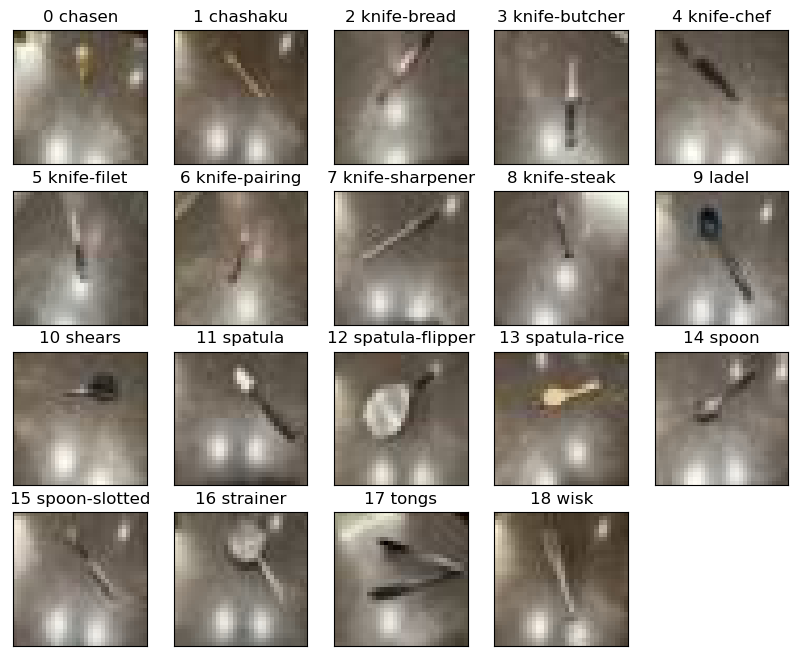

In [9]:
path = 'kitchen_utensils'
image_width = 32
image_height = 32
# Use the load_data function to load the dataset
train_dl, tests_dl, labels = load_data(path, 
                                       batch_size=16, 
                                       image_width=image_width,
                                       image_height=image_height,
                                       transform_train=None, 
                                       transform_test=None, 
                                       valid=False,
                                       display=True)

In [10]:
# Build the model
model = build_model(image_width, image_height)

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 128, 30, 30]         1,280
├─ReLU: 1-2                              [-1, 128, 30, 30]         --
├─MaxPool2d: 1-3                         [-1, 128, 10, 10]         --
├─BatchNorm2d: 1-4                       [-1, 128, 10, 10]         256
├─Conv2d: 1-5                            [-1, 32, 8, 8]            36,896
├─ReLU: 1-6                              [-1, 32, 8, 8]            --
├─MaxPool2d: 1-7                         [-1, 32, 2, 2]            --
├─BatchNorm2d: 1-8                       [-1, 32, 2, 2]            64
├─Flatten: 1-9                           [-1, 128]                 --
├─Linear: 1-10                           [-1, 128]                 16,512
├─ReLU: 1-11                             [-1, 128]                 --
├─Linear: 1-12                           [-1, 19]                  2,451
├─Softmax: 1-13                          [-1, 19]                  --


In [12]:
# Train the model
history, model = train(model=model,
                       num_epochs=75,
                       train_dl=train_dl,
                       valid_dl=None,
                       optimizer='rmsprop',
                       loss_fn='crossentropy',
                       lr=0.001,
                       device='cuda:0')

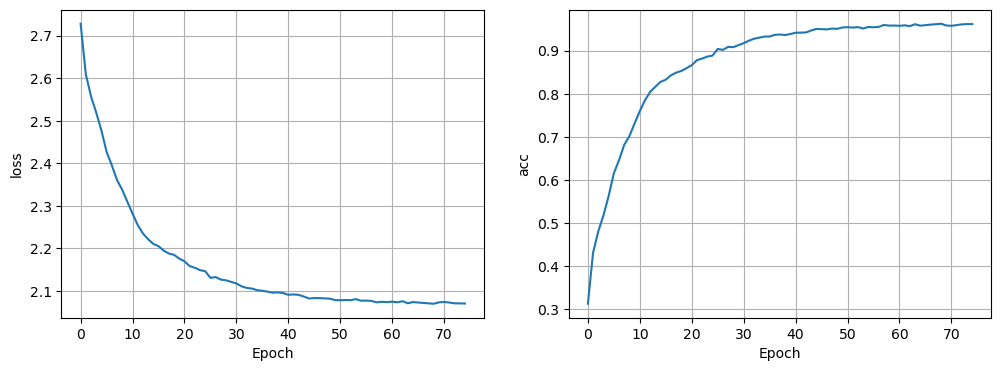

In [13]:
# Plot the training history
plot_history(history)

                 precision    recall  f1-score   support

         chasen       1.00      0.98      0.99        45
       chashaku       0.89      1.00      0.94        34
    knife-bread       0.88      1.00      0.93        42
  knife-butcher       0.97      0.97      0.97        40
     knife-chef       0.96      0.94      0.95        80
    knife-filet       0.95      0.73      0.83        52
  knife-pairing       1.00      0.82      0.90        11
knife-sharpener       0.86      1.00      0.92        18
    knife-steak       0.95      0.98      0.97        43
          ladel       0.99      0.99      0.99        82
         shears       0.95      1.00      0.97        37
        spatula       0.96      0.97      0.97       191
spatula-flipper       0.96      0.99      0.97       188
   spatula-rice       1.00      0.51      0.68        94
          spoon       0.74      0.92      0.82       165
  spoon-slotted       0.93      0.91      0.92       124
       strainer       1.00    

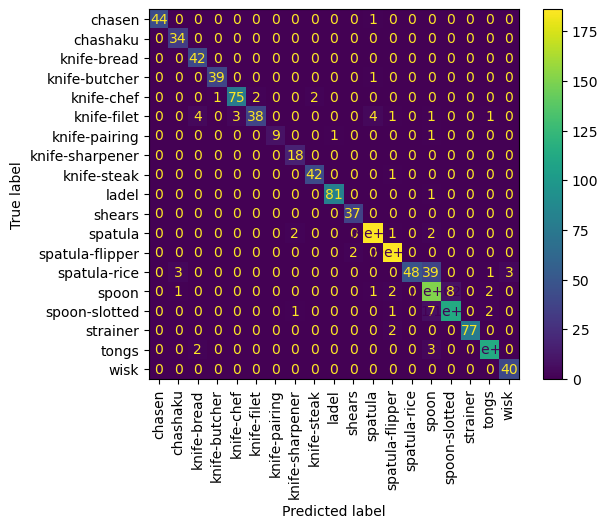

In [14]:
# Test the model
acc = test(model, tests_dl, labels, verbose=1, device='cuda:0')